In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt


#import the Cross sections file 
openmc.config['cross_sections'] = "/home/f_z/endfb-vii.1-hdf5/cross_sections.xml"

In [30]:
#import the right geometry and materials for the two types of rods
#zircaloy
#materials = openmc.Materials.from_xml('materials_zr.xml')
#geometry = openmc.Geometry.from_xml('geometry_zr.xml')
#fecral advanced steel
materials = openmc.Materials.from_xml('materials.xml')
geometry = openmc.Geometry.from_xml('geometry.xml')

/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=4.
  warn(msg, IDWarning)
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=5.
  warn(msg, IDWarning)
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=2

In [33]:
#let's define the parameters for the construction of the assembly (squared 17*17)

frod_height=385.866  
pitch=1.26
bundle_pitch=17*pitch

outer_boundary = openmc.model.RectangularPrism(
        bundle_pitch, bundle_pitch, boundary_type='reflective')


fuel_rod_universe= geometry.get_all_universes()[3] #this is to verify the import of the geometry. 
#I'm importing the universe from the geometry file, in particular it's the third universe ([2])
'''
fuel_rod_universe.plot(basis="xz",width=(1.5,390.9),color_by= 'material') #infinitely defined lateraly
fuel_rod_universe.plot(basis="xy",width=(1.5,1.5),color_by= 'material')
fuel_rod_universe.plot(basis="yz",width=(1.5,1.5),color_by= 'material') 
'''

#let's create the bundle
bundle_lattice= openmc.RectLattice(name='Fuel Assembly')
bundle_lattice.pitch = (pitch, pitch)
bundle_lattice.lower_left = (-bundle_pitch/2, -bundle_pitch/2)

bundle_lattice.universes = np.full((17, 17), fuel_rod_universe)
bundle_cell = openmc.Cell(fill=bundle_lattice, region=-outer_boundary)

bundle_universe= openmc.Universe (cells= [bundle_cell])
bundle_universe.plot(basis='xz',width=(22,390), color_by= 'material',origin =[0,0,0])
bundle_universe.plot(basis='xy',width=(22,22),pixels=(700,700), color_by= 'material',origin =[0,0,0])

#export the geometry of the assembly
bundle_geom=openmc.Geometry(bundle_universe) #before we didn't define the class
bundle_geom.export_to_xml('geometry.xml')

NameError: name 's_top' is not defined

In [19]:
#we can now use the geometry to calculate the so called "tallies"
#those will have all the same structure:
#triple integrale over (E,angle,r) multiplied by the flux


#let's define the "filters"
#in the parentesis we have the energy groups in Ev (0-->0.68; 0.68-->20*10^6)
e_filter=openmc.EnergyFilter([0.0,0.68,20e6])
#filter for the spatial information (discretization)
msh_filter=openmc.RegularMesh(mesh_id=1)
msh_filter.dimension=(250,250,1)
#we define the most negative and positive point creating a parallelepide that comprehends everything
#we define the most negative and the most positive corner
msh_filter.lower_left= [-bundle_pitch/2, -bundle_pitch/2,-frod_height/2]
msh_filter.upper_right= [bundle_pitch/2, bundle_pitch/2,frod_height/2]
mesh_filter= openmc.MeshFilter(msh_filter)#,filter_id=1) 

#let's calculate tallies!!

flux= openmc.Tally(tally_id=1,name= 'Flux')
flux.scores= ['flux']
flux.filters= [e_filter, mesh_filter]
#
fission_rr =openmc.Tally (tally_id=2,name='Fission reaction rate')
fission_rr.scores = ['fission']
fission_rr.filters = [e_filter, mesh_filter]
#
tallies = openmc.Tallies([flux,fission_rr])
tallies.export_to_xml()
#!cat.tallies.xml

/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=2.
  warn(msg, IDWarning)


In [27]:
#we have now to define the number of generations of neutrons. Particularly we will
#define a numeber of inactive cycles that will not be counted so that we reach the
#fundamental harmonic. If the inactive number is great enough aumenting it shouldn't have any 
#effect on the calculation

source_point= openmc.stats.Point(xyz=(0.0,0.0,0.0))
#we define a parallelepipedo box inside teh bundle
#this represents only where the starting gen of neutrons will appear
#this will not affect the calculations results but only the convergence speed
source_region= openmc.stats.Box((-1.5,-1.5,-21.5),(1.5,1.5,21.5), only_fissionable=True)
source_energy= openmc.stats.Watt( a=988000.0,b=2.249e-06)
source1 = openmc.Source(space=source_point,energy=source_energy)
source2 = openmc.Source(space=source_region,energy=source_energy)
#we are performing a criticality calculation, for this reason we impose 50000 neutrons for each batch
sim_settings= openmc.Settings()
sim_settings.run_mode='eigenvalue'
sim_settings.particles =50000
sim_settings.inactive=2
sim_settings.batches=15
sim_settings.source= source2
#we export also the simulation settings in te xml file
sim_settings.export_to_xml()
#!cat settings.xml


/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/stats/multivariate.py:829: FutureWarning: The 'only_fissionable' has been deprecated. Use the 'constraints' argument when defining a source instead.
  warn("The 'only_fissionable' has been deprecated. Use the "
/home/f_z/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/source.py:656: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [28]:
openmc.run()


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Using statepoint: statepoint.15.h5
(125000, 1, 1)


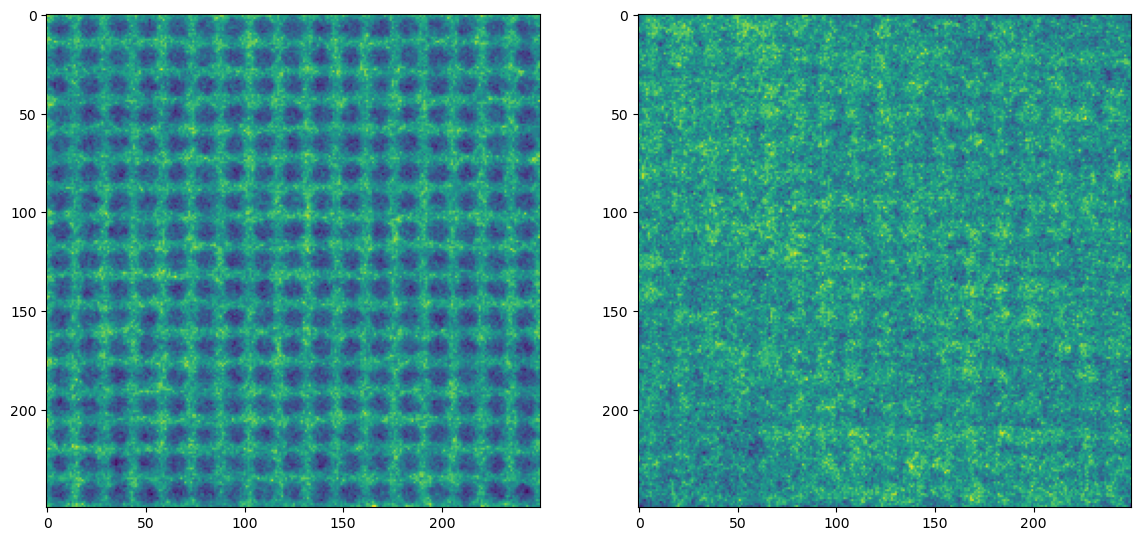

In [29]:
###How to verify that the sources are working, use of the h5 file
import glob
#function to search for the right statepoint file
def get_latest_statepoint():
    files = sorted(glob.glob("statepoint.*.h5"))
    return files[-1] if files else None  # Return None if no file exists

latest_file = get_latest_statepoint()
if latest_file:
    sp_file = openmc.StatePoint(latest_file)
    print(f"Using statepoint: {latest_file}")
else:
    print("No statepoint file found!")

#sp_file=openmc.StatePoint("statepoint.100.h5") #to be changed every time you re-run the code
'''
plt.quiver(sp_file.source["r"]["x"],sp_file.source["r"]["y"],sp_file.source["u"]["x"],sp_file.source["u"]["y"],
           np.log(sp_file.source["E"]),cmap="jet",scale=15.)#help to visualize the population and directions from the source 

plt.colorbar()
plt.ylim(-bundle_pitch/2, bundle_pitch/2)
plt.xlim(-bundle_pitch/2, bundle_pitch/2)

flux_tally = sp_file.get_tally(scores=['fission'], name='fission_rate') #instead you can do the same for the flux
flux_data=flux_tally.get_reshaped_data()

print(flux_tally.shape,flux_data.shape)
plt.imshow(flux_data[:, :, 0], extent=[-bundle_pitch/2, bundle_pitch/2, -bundle_pitch/2, bundle_pitch/2], origin='lower', cmap='inferno')
plt.colorbar(label='Neutron Flux')
plt.xlabel('X Position (cm)')
plt.ylabel('Y Position (cm)')
plt.title('Neutron Flux in X-Y Plane at Z = 10 cm')
plt.show()
#K_eff plot
plt.plot(sp_file.k_generation)
'''

###tally extraction:sp_file.get_tally(scores=["fission"],name=fission_rr) you need the name of the tally
#divide for each energy groups: use the energy filter "get_slicer function", use print(.shape to see the dimensions of the arrays)
#reshape the array of the sliced array(the square of the original mesh) using the function "mean.shape =(25,25)"
fr_tally = sp_file.get_tally(scores=['flux'], name='Flux') #instead you can do the same for the flux
#fr_tally = sp_file.get_tally(scores=['flux'], name='Flux') #instead you can do the same for the flux

print(fr_tally.shape)

fr1 = fr_tally.get_slice(filters=[openmc.EnergyFilter], filter_bins=[((0, 0.68),)])
fr2 = fr_tally.get_slice(filters=[openmc.EnergyFilter], filter_bins=[((0.68, 20e6),)])
# Correcting the shape mismatch
#fr1.mean = fr1.mean.sum(axis=-1).reshape(25, 25)  # Summing over z bins
#fr2.mean = fr2.mean.sum(axis=-1).reshape(25, 25)
fr1.mean.shape = (250, 250)
fr2.mean.shape = (250, 250)

plt.rcParams['figure.figsize'] = [14, 10]
fig = plt.subplot(121)
fig1 = plt.imshow(fr1.mean, label="E < 1 keV")
fig2 = plt.subplot(122)
fig2.imshow(fr2.mean, label="E > 800 keV")
